## Income prediction using US Census Income Dataset 
    The purpose of this analysis is to examine the US census income data, explore the distribution of individual variables as well as the relation between them. Finally, the goal is to build a model which will be able to predict the income based on the variables given in the dataset. 
    
    The analysis and modelling are performed in Python relying on Pandas library for data preparation and statistical analysis, sci-kit learn and H2O for creating predictive models. The results are satisfactory for the scope of this taks, with final models achieving an above 90% accuracy.
    
#### Contents

* [0. Import libraries](#zeroth-bullet)
* [1. Load metadata file and extract column names](#first-bullet)
* [2. Load train and test datasets and identify the target](#second-bullet)
* [3. Exploratory data analysis](#third-bullet)
* [4. Missing values, Subsampling, Feature Engineering](#fourth-bullet)
* [5. Training](#fifth-bullet)
* [6. Build model with H2O AutoML](#sixth-bullet)
* [7. Conclusion](#seventh-bullet)

## 0. Import libraries <a class="anchor" id="zeroth-bullet"></a>

In [18]:
import pandas as pd, re, json, random, os, datetime, numpy as np
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.cross_validation import KFold, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.automl import H2OAutoML

## 1. Load metadata file and extract column names <a class="anchor" id="first-bullet"></a>

In [2]:
f = open("/home/armend/dataiku/us_census_full/census_income_metadata.txt", "r")
meta = "".join([line for line in f])

key_pattern1 = re.compile("[^A-Za-z\d\s\-\']")
key_pattern2 = re.compile('[^a-zA-Z\d]+')
value_pattern = re.compile("[^A-Za-z\d\s\-,]")

### Create a dict of attributes and their values
meta_dict = {re.sub(key_pattern2, "_", re.sub(key_pattern1, '', i.split(": ")[0]).strip()):re.sub(value_pattern, '', i.split(": ")[1]).strip() for i in meta.split("- 50000, 50000+.\n\n")[1].split('\n')[:-1]}
meta_dict['class']="-50000, 50000+"

### Create a list of column names from attribute names
meta = [re.sub(key_pattern2, "_", re.sub(key_pattern1, '', i.split(": ")[0]).strip()) for i in meta.split("- 50000, 50000+.\n\n")[1].split('\n')[:-1]]
print "Number of columns: {}".format(len(meta))
columns = list(OrderedDict.fromkeys([re.sub(key_pattern2, '_', c) for c in meta if re.sub(key_pattern2, '_', c)]))
columns.append('class')

Number of columns: 42


In [3]:
print meta

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Terran Lane and Ronny Kohavi
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.
|
| The data was split into train/test in approximately 2/3, 1/3
| proportions using MineSet's MIndUtil mineset-to-mlc.
|
| Prediction task is to determine the income level for the person
| represented by the record.  Incomes have been binned at the $50K
| level to present a binary classification problem, much like the
| original UCI/ADULT database.  The goal field of this data, however,
| was drawn from the "total person income" field rather than the
| "adjusted gross income" and may, therefore, behave differently than the
| orginal ADULT goal field.
|
| More information detailing the meaning of the attributes can be
| found in http://www.bls.census.gov/cps/cpsmain.htm
| To make use of the data d

In [3]:
meta_dict

{'age': 'continuous',
 'capital_gains': 'continuous',
 'capital_losses': 'continuous',
 'citizenship': 'Native- Born in the United States, Foreign born- Not a citizen of U S , Native- Born in Puerto Rico or U S Outlying, Native- Born abroad of American Parents, Foreign born- U S citizen by naturalization',
 'class': '-50000, 50000+',
 'class_of_worker': 'Not in universe, Federal government, Local government, Never worked, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay',
 'country_of_birth_father': 'Mexico, United-States, Puerto-Rico, Dominican-Republic, Jamaica, Cuba, Portugal, Nicaragua, Peru, Ecuador, Guatemala, Philippines, Canada, Columbia, El-Salvador, Japan, England, TrinadadTobago, Honduras, Germany, Taiwan, Outlying-U S Guam USVI etc, India, Vietnam, China, Hong Kong, Cambodia, France, Laos, Haiti, South Korea, Iran, Greece, Italy, Poland, Thailand, Yugoslavia, Holand-Netherlands, Ireland, Scotland, Hungary, Panama',
 'country

In [4]:
# Create continuous and categorical variables lists
continuous = [k for k,v in meta_dict.iteritems() if v=='continuous']
continuous.remove('instance_weight')
categorical = [k for k,v in meta_dict.iteritems() if v!='continuous']
print "Continuous: {}".format(continuous)
print "\nCategorical: {}".format(categorical)

Continuous: ['capital_gains', 'dividends_from_stocks', 'num_persons_worked_for_employer', 'weeks_worked_in_year', 'capital_losses', 'wage_per_hour', 'age']

Categorical: ['country_of_birth_self', 'tax_filer_stat', 'member_of_a_labor_union', 'detailed_household_summary_in_household', 'sex', 'full_or_part_time_employment_stat', 'year', 'live_in_this_house_1_year_ago', 'education', 'country_of_birth_mother', 'citizenship', 'marital_stat', 'migration_code_move_within_reg', 'enroll_in_edu_inst_last_wk', 'class', 'detailed_occupation_recode', 'migration_code_change_in_reg', 'detailed_industry_recode', 'hispanic_origin', 'migration_prev_res_in_sunbelt', 'veterans_benefits', 'fill_inc_questionnaire_for_veteran_s_admin', 'migration_code_change_in_msa', 'reason_for_unemployment', 'family_members_under_18', 'major_industry_code', 'own_business_or_self_employed', 'country_of_birth_father', 'major_occupation_code', 'class_of_worker', 'race', 'region_of_previous_residence', 'detailed_household_and_f

## 2. Load train and test datasets and identify the target <a class="anchor" id="second-bullet"></a>

In [78]:
train = pd.read_csv("/home/armend/dataiku/us_census_full/census_income_learn.csv", header=None, names=columns)
test = pd.read_csv("/home/armend/dataiku/us_census_full/census_income_test.csv", header=None, names=columns)

In [79]:
## Find unique class categories
train['class'].unique()

array([' - 50000.', ' 50000+.'], dtype=object)

In [80]:
## Create target column with binary values
train['target']=train['class'].map({train['class'].unique()[0]: 0, train['class'].unique()[1]: 1})
test['target']=test['class'].map({test['class'].unique()[0]: 0, test['class'].unique()[1]: 1})

## 3. Exploratory data analysis <a class="anchor" id="third-bullet"></a>

#### First and foremost I am curious to the proportion of positive/ negative samples over the train set. It turns out that the distribution is highly uneven. A model built with this distribution would be biased. I will treat this further down the process.

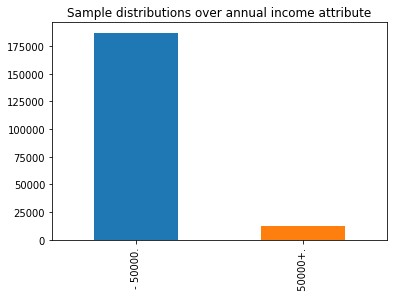

In [8]:
train['class'].value_counts().plot(kind='bar', title='Sample distributions over annual income attribute')

In [9]:
positives = train[train['target']==1]
positives.shape

(12382, 43)

In [10]:
print test.shape
test_positive = test[test['target']==1]
test_positive.shape

(99762, 43)


(6186, 43)

In [11]:
train_cont = train[continuous+['target']]
train_cont.head()

,capital_gains,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,capital_losses,wage_per_hour,age,target
0,0,0,0,0,0,0,73,0
1,0,0,1,52,0,0,58,0
2,0,0,0,0,0,0,18,0
3,0,0,0,0,0,0,9,0
4,0,0,0,0,0,0,10,0


Text(0.5,1,u'Correlation between continuous variables')

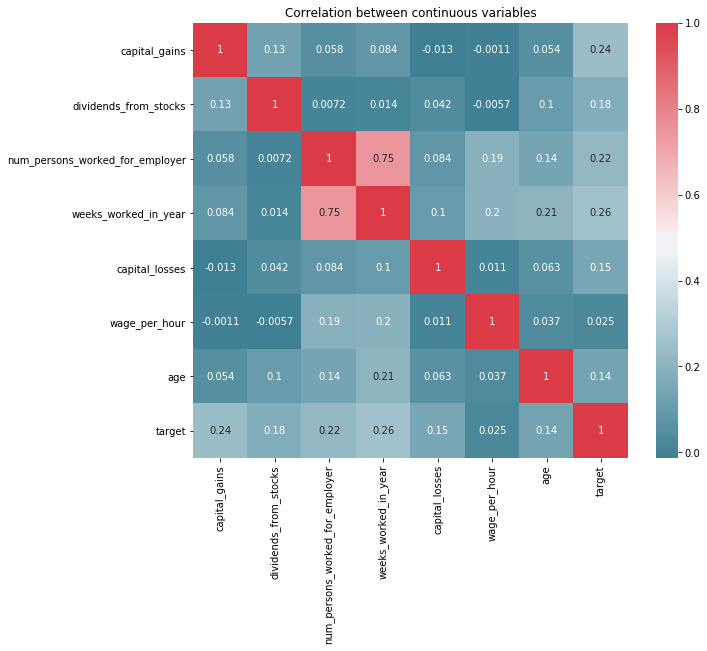

In [12]:
### Correlation matrix of continuous variables
f, ax = plt.subplots(figsize=(10, 8))

corr = train_cont.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax).set_title("Correlation between continuous variables")

In [13]:
train[continuous].describe(include=np.number)

,capital_gains,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year,capital_losses,wage_per_hour,age
count,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,434.71899,197.529533,1.956180,23.174897,37.313788,55.426908,34.494199
std,4697.53128,1984.163658,2.365126,24.411488,271.896428,274.896454,22.310895
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,0.00000,0.000000,1.000000,8.000000,0.000000,0.000000,33.000000
75%,0.00000,0.000000,4.000000,52.000000,0.000000,0.000000,50.000000
max,99999.00000,99999.000000,6.000000,52.000000,4608.000000,9999.000000,90.000000


In [14]:
train[categorical].describe(include=np.object)

,country_of_birth_self,tax_filer_stat,member_of_a_labor_union,detailed_household_summary_in_household,sex,full_or_part_time_employment_stat,live_in_this_house_1_year_ago,education,country_of_birth_mother,citizenship,...,reason_for_unemployment,family_members_under_18,major_industry_code,country_of_birth_father,major_occupation_code,class_of_worker,race,region_of_previous_residence,detailed_household_and_family_stat,state_of_previous_residence
count,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523,...,199523,199523,199523,199523,199523,199523,199523,199523,199523,199523
unique,43,6,3,8,2,8,3,17,43,5,...,6,5,24,43,15,9,5,6,38,51
top,United-States,Nonfiler,Not in universe,Householder,Female,Children or Armed Forces,Not in universe under 1 year old,High school graduate,United-States,Native- Born in the United States,...,Not in universe,Not in universe,Not in universe or children,United-States,Not in universe,Not in universe,White,Not in universe,Householder,Not in universe
freq,176989,75094,180459,75475,103984,123769,101212,48407,160479,176992,...,193453,144232,100684,159163,100684,100245,167365,183750,53248,183750


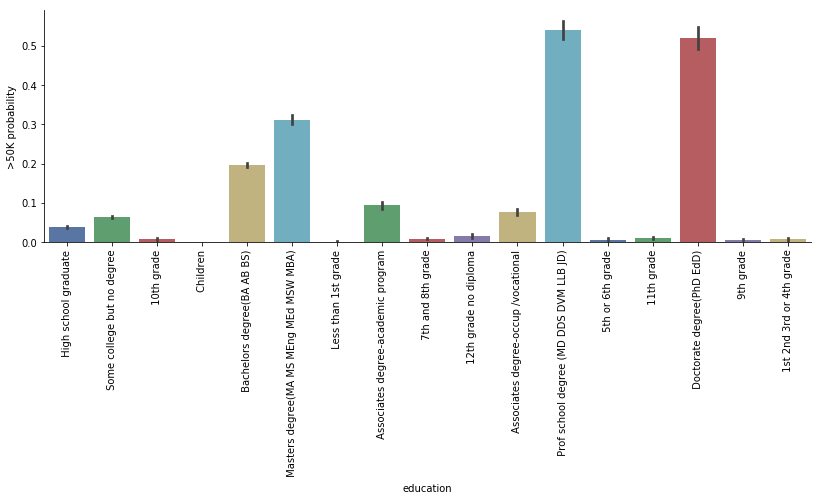

In [15]:
### Education vs. income
g = sns.factorplot(x="education", y="target", data=train, kind="bar", aspect=3, palette="deep")
g.set_xticklabels(rotation=90)
g = g.set_ylabels(">50K probability")

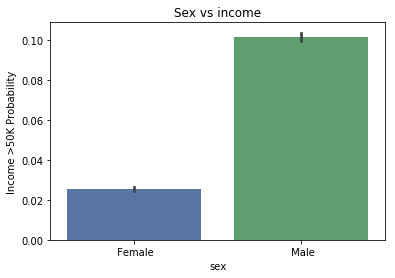

In [16]:
### Sex vs income
g = sns.barplot(x="sex", y="target", data=train, palette="deep")
g.set_title("Sex vs income")
g = g.set_ylabel("Income >50K Probability")

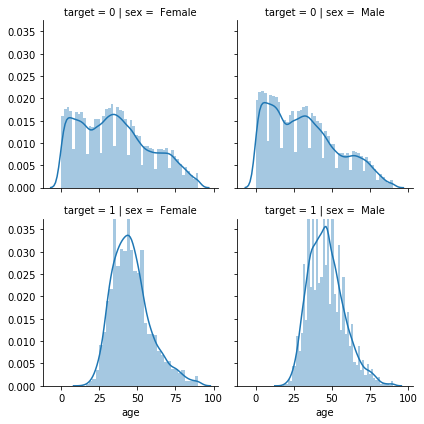

In [59]:
g = sns.FacetGrid(train, row='target', col='sex')
g.map(sns.distplot, "age")
plt.show()

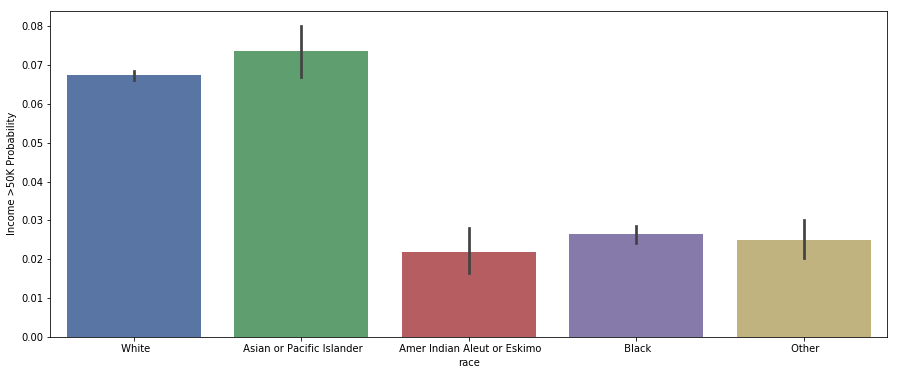

In [19]:
### Race vs income
g = sns.barplot(x="race", y="target",data=train, palette="deep")
g = g.set_ylabel("Income >50K Probability")

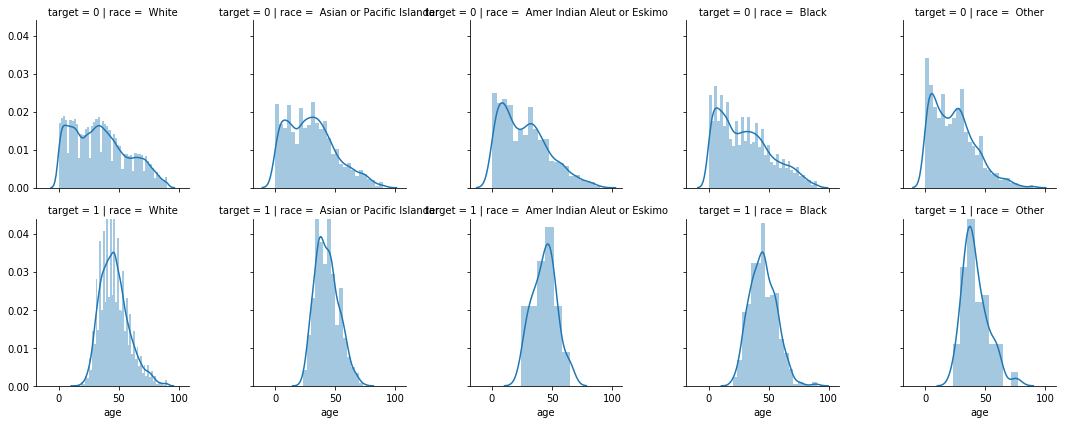

In [58]:
g = sns.FacetGrid(train, row='target', col='race')
g.map(sns.distplot, "age")
plt.show()

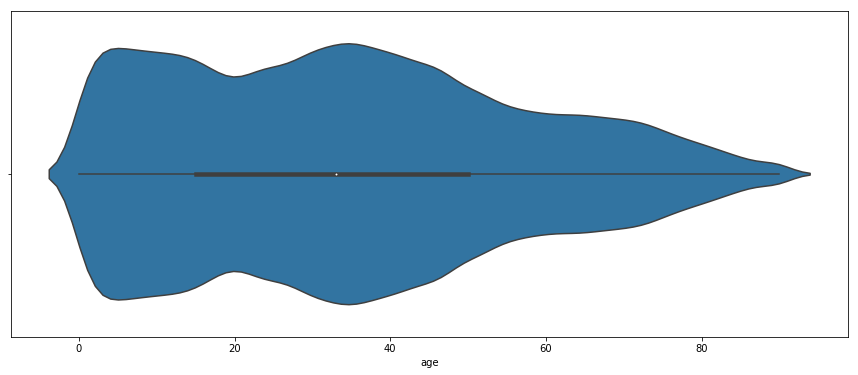

In [21]:
sns.violinplot(data=train, x='age')

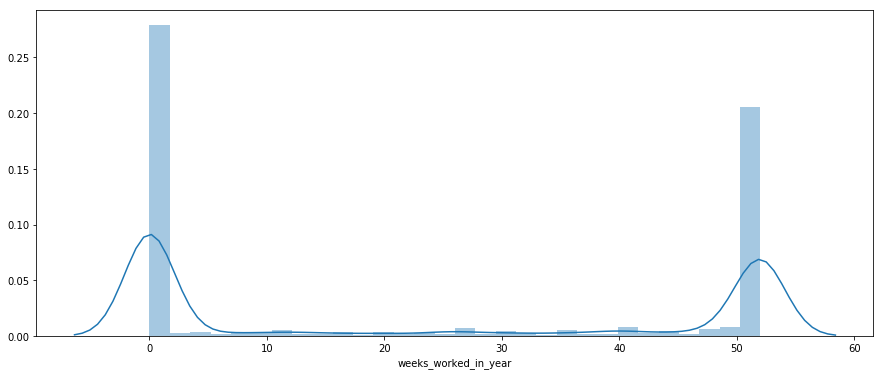

In [45]:
sns.distplot(train.weeks_worked_in_year)

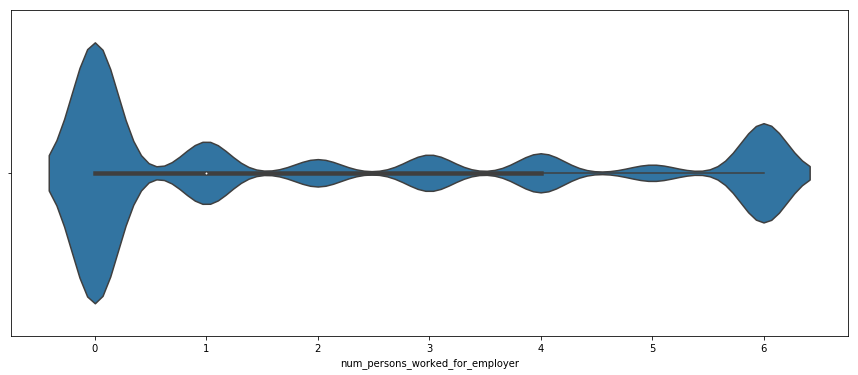

In [24]:
sns.violinplot(data=train, x=train.num_persons_worked_for_employer)

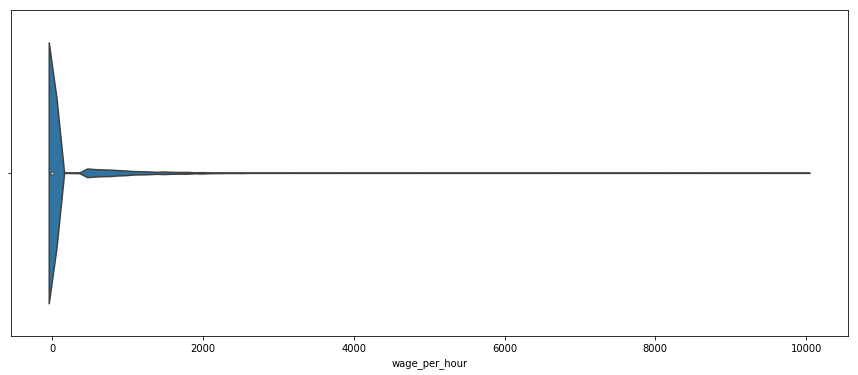

In [25]:
sns.violinplot(data=train, x=train.wage_per_hour)

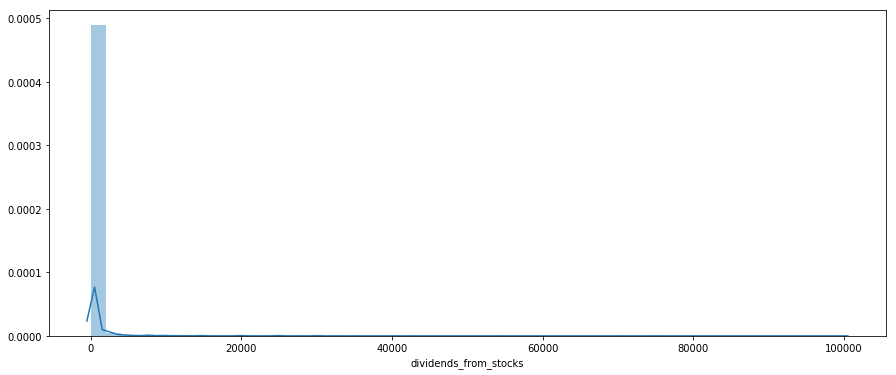

In [49]:
sns.distplot(train.dividends_from_stocks)

### Outlier detection
<b>NOTE:</b> Here ideally one would be able to detect outliers. They may be present due to several factors such as failure of measurement instruments, wrong input and so on. In this dataset I looked for generic variables outliers such as age, sex, and weeks worked per year which where outliers can be detected using common sense but the distribution is well within boundaries. For specific variables like caital gains/losses, one might suspect outliers here but unless having domain expertise it is safer to leave the distribution intact.

## 4. Missing values, Subsampling, Feature Engineering <a class="anchor" id="fourth-bullet"></a>

### 4.1. Missing values
Inspect columns for missing values.

In [61]:
### Inspect size, shape, and datatypes of the dataframe
print "Dataframe shape and memory usage: {}, ~{}MB\n".format(train.shape, train.memory_usage(index=False).sum()/1000000)
print "Columns: "
print train.dtypes
train.head(5)

Dataframe shape and memory usage: (199523, 43), ~68MB

Columns: 
age                                             int64
class_of_worker                                object
detailed_industry_recode                        int64
detailed_occupation_recode                      int64
education                                      object
wage_per_hour                                   int64
enroll_in_edu_inst_last_wk                     object
marital_stat                                   object
major_industry_code                            object
major_occupation_code                          object
race                                           object
hispanic_origin                                object
sex                                            object
member_of_a_labor_union                        object
reason_for_unemployment                        object
full_or_part_time_employment_stat              object
capital_gains                                   int64
capital_losses   

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran_s_admin,veterans_benefits,weeks_worked_in_year,year,class,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,0


In [62]:
print "Null value counts:"
train.isna().sum()

Null value counts:


age                                           0
class_of_worker                               0
detailed_industry_recode                      0
detailed_occupation_recode                    0
education                                     0
wage_per_hour                                 0
enroll_in_edu_inst_last_wk                    0
marital_stat                                  0
major_industry_code                           0
major_occupation_code                         0
race                                          0
hispanic_origin                               0
sex                                           0
member_of_a_labor_union                       0
reason_for_unemployment                       0
full_or_part_time_employment_stat             0
capital_gains                                 0
capital_losses                                0
dividends_from_stocks                         0
tax_filer_stat                                0
region_of_previous_residence            

#### Note: It appears that there are no missing values in the dataset. But I remember I have seen some '?' scattered in the dataframe. '?' in the context of attributes given in this dataframe does not reveal any valuable information and I will treat it as a missing value. I will temporarily replace '?' with Na and use .isna() to run counts just to get an impression of its presence, after that I replace it back with '?'.

In [63]:
### Replace ' ?' with NaN
train.replace(r' ?', np.nan, regex=False, inplace=True)

                                count
state_of_previous_residence       708
migration_code_change_in_msa    99696
migration_code_change_in_reg    99696
migration_code_move_within_reg  99696
migration_prev_res_in_sunbelt   99696
country_of_birth_father          6713
country_of_birth_mother          6119
country_of_birth_self            3393


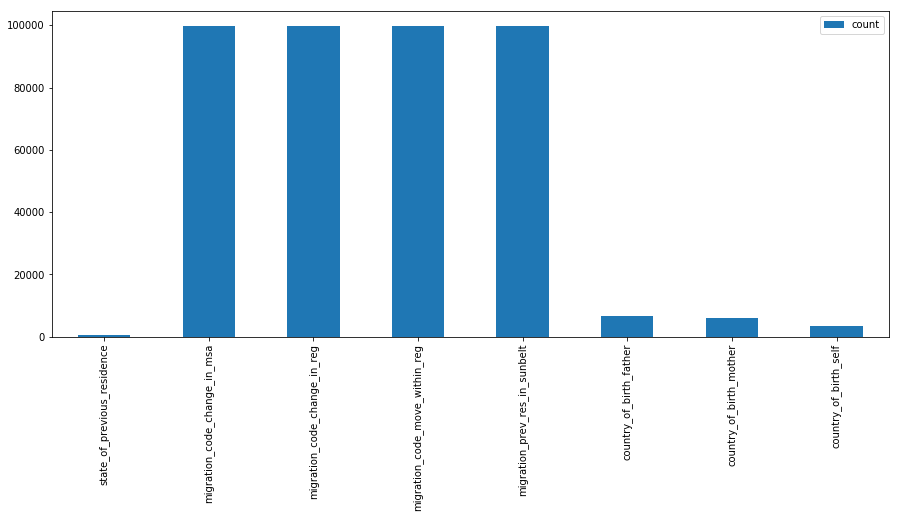

In [64]:
### Count columns with missing values again
missing = pd.DataFrame(train.isna().sum(), columns=['count'])
missing = missing[missing['count']>0]
print missing
missing.plot(kind='bar')

In [65]:
### Drop samples containing any missing value
train.fillna(value=' ?', inplace=True)

In [66]:
train.shape

(199523, 43)

In [67]:
print "Null value counts:"
train.isna().sum()

Null value counts:


age                                           0
class_of_worker                               0
detailed_industry_recode                      0
detailed_occupation_recode                    0
education                                     0
wage_per_hour                                 0
enroll_in_edu_inst_last_wk                    0
marital_stat                                  0
major_industry_code                           0
major_occupation_code                         0
race                                          0
hispanic_origin                               0
sex                                           0
member_of_a_labor_union                       0
reason_for_unemployment                       0
full_or_part_time_employment_stat             0
capital_gains                                 0
capital_losses                                0
dividends_from_stocks                         0
tax_filer_stat                                0
region_of_previous_residence            

### 4.2. Encoding categorical fields, subsampling, and prepare for fitting the classifier

In [101]:
### Prepare the train set

d = defaultdict(LabelEncoder)

# Encoding the variables
train_enc = train[categorical].apply(lambda x: d[x.name].fit_transform(x))

# Inverse the encoded
train_enc.apply(lambda x: d[x.name].inverse_transform(x))

#X = pd.concat([train[continuous], train_enc], axis=1)
#X.drop('class', axis=1, inplace=True)

# Concat continuous and categorical variables, drop class (-50000/50000+)
train_enc = pd.concat([train[continuous], train_enc, train.target], axis=1)

# Split positive and negative samples
X_pos = train_enc[train_enc.target==1]
X_neg = train_enc[train_enc.target==0]

# Subsample the negative set, extract a number of random samples 
# equal to the number of positive samples
X = pd.concat([X_neg.sample(X_pos.shape[0]), X_pos])
y = X.target
X.drop(['class', 'target'], axis=1, inplace=True)

/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

In [102]:
### Prepare the test set

d = defaultdict(LabelEncoder)

test_enc = test[categorical].apply(lambda x: d[x.name].fit_transform(x))
test_enc.apply(lambda x: d[x.name].inverse_transform(x))

X_test = pd.concat([test[continuous], test_enc], axis=1)
X_test.drop('class', axis=1, inplace=True)

test_enc = pd.concat([test[continuous], test_enc, test.target], axis=1)
X_test_pos = test_enc[test_enc.target==1]
X_test_neg = test_enc[test_enc.target==0]

X_test = pd.concat([X_test_neg.sample(X_test_pos.shape[0]), X_test_pos])
y_test = X_test.target
X_test.drop(['class', 'target'], axis=1, inplace=True)

/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/armend/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Re

In [103]:
X_test.shape

(12372, 40)

### 4.3. Feature importance
Train a baseline LogisticRegression model and examine feature importance

In [96]:
# use complete dataset for running feature importance
y_complete = train_enc.target
X_complete = train_enc.drop(['class', 'target'], axis=1)

# create a base classifier used to evaluate a subset of attributes
logreg = LogisticRegression()

# create the RFE model and select 3 attributes
rfe = RFE(logreg, 3)
rfe = rfe.fit(X_complete, y_complete)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False  True
 False False False False False False False False  True False False False
 False False False False False False  True False False False False False
 False False False False]
[37 36  6 16 35 38 23 33  9 14 25  1 31  4  5 21 34 27 12 19  1 15 17 29
 10 11  3  2  7 22  1 24 28 32 20 18  8 13 26 30]


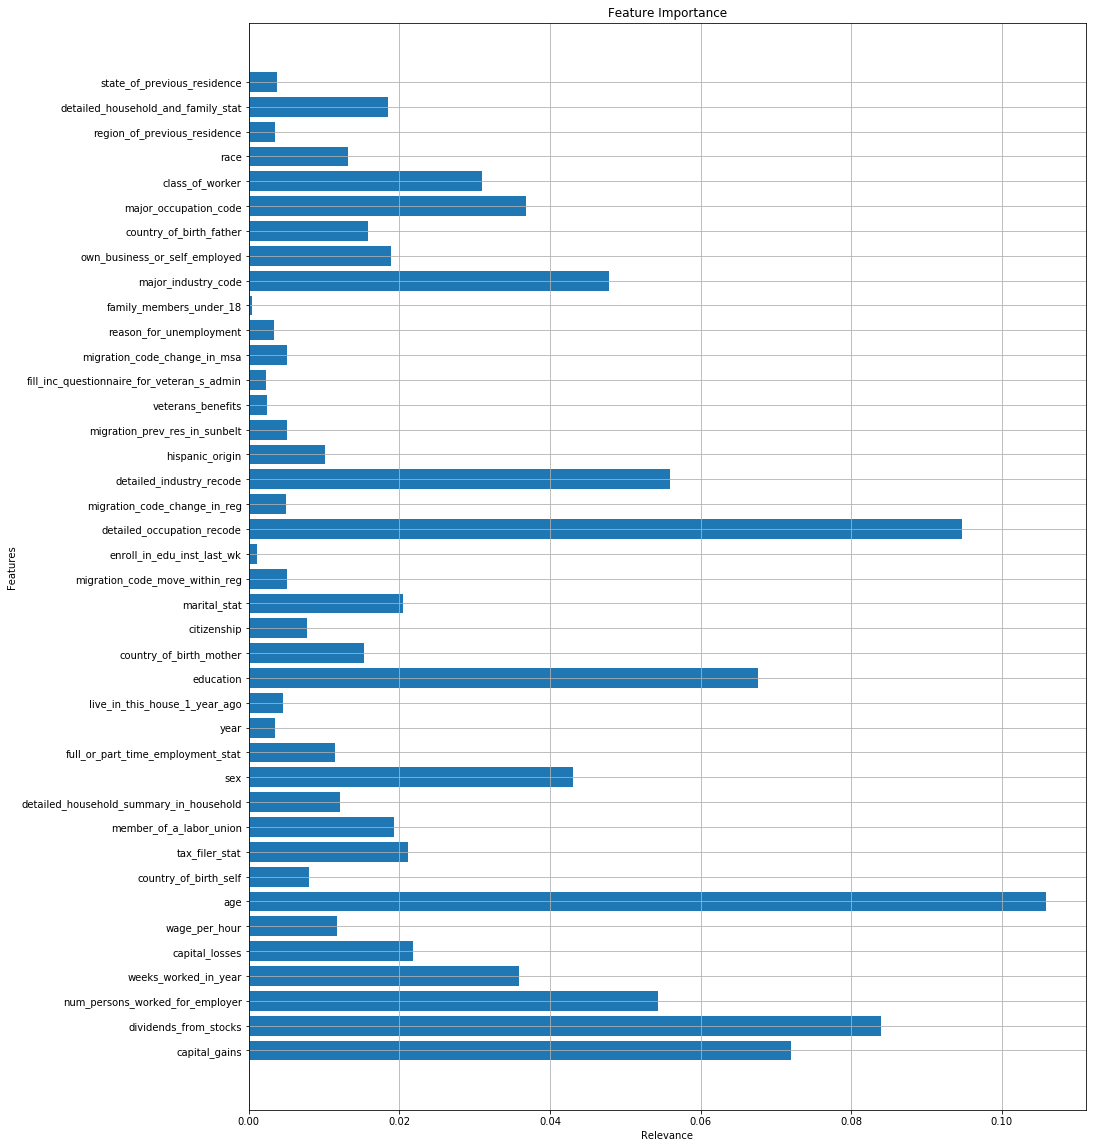

In [97]:
# fit an Extra Tree model to the data
extree = ExtraTreesClassifier()
extree.fit(X_complete, y_complete)

# display the relative importance of each attribute
relevance = extree.feature_importances_

# horizontal bar plot of feature importance
pos = np.arange(X.columns.shape[0]) + 0.5
plt.barh(pos, relevance, align='center')
plt.title("Feature Importance")
plt.xlabel("Relevance")
plt.ylabel("Features")
plt.yticks(pos, (X.columns))
plt.grid(True)
plt.rcParams['figure.figsize'] = (15, 20)

In [98]:
### Show feature importance ranking as a dataframe sorted by importance in descending order
relevance = extree.feature_importances_
pd.DataFrame(relevance, X_complete.columns, columns=['importance']).sort_values("importance", ascending=False)

,importance
age,0.105843
detailed_occupation_recode,0.094707
dividends_from_stocks,0.083994
capital_gains,0.072032
education,0.067570
detailed_industry_recode,0.055874
num_persons_worked_for_employer,0.054309
major_industry_code,0.047830
sex,0.043105
major_occupation_code,0.036758


## 5. Training <a class="anchor" id="fifth-bullet"></a>

### 5.2. Evaluate LogisticRegression model using cross-validation

In [104]:
# instantiate
logreg = LogisticRegression()

# fit
logreg.fit(X, y)

# predict
y_pred = logreg.predict(X_test)

print('LogReg %s' % metrics.accuracy_score(y_test, y_pred))

LogReg 0.8519236986744261


In [105]:
# KFolds and Cross_val_scores

kf = KFold(n_splits=10, shuffle=False)
print('KFold CrossValScore %s' % cross_val_score(logreg, X, y, cv=kf).mean())

KFold CrossValScore 0.8156235590371645


#### The LogisticRegression model was insightful. It gave a baseline accuracy as a reference and generated a ranking of the feature importance. Next I will build a new model using RandomFoerest algorithm.

### 5.3. Create a RandomForest classifier

In [106]:
# instantiate
rf = RandomForestClassifier(n_estimators=250,max_features=5)

# fit
rf.fit(X, y)

# predict
y_pred = rf.predict(X_test)

print('RandomForest %s' % metrics.accuracy_score(y_test, y_pred))

RandomForest 0.8718073068218558


In [107]:
kf = KFold(n_splits=10, shuffle=False)
print('KFold CrossValScore %s' % cross_val_score(rf, X, y, cv=kf).mean())

KFold CrossValScore 0.8457067378525407


In [108]:
print("Accuracy: %s%%" % (100*accuracy_score(y_test, y_pred)))
print "\nConfusion matrix\n================"
print(confusion_matrix(y_test, y_pred))
print "\nClassification report\n================"
print(classification_report(y_test, y_pred))

Accuracy: 87.18073068218558%

Confusion matrix
[[5288  898]
 [ 688 5498]]

Classification report
             precision    recall  f1-score   support

          0       0.88      0.85      0.87      6186
          1       0.86      0.89      0.87      6186

avg / total       0.87      0.87      0.87     12372



#### RandomForest model gives higher accuracy. I wanted to do some hyperparameter tuning here and see whether it helps to improve the accuracy further. I am using GridSearch here to randomly search the hyperparameter space for the optimal values.

### 5.4. RandomForest with GridSearch

In [136]:
# Utility function to report best scores
def report(results, n_top=5):
    res = []
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            res.append({"mean_test_score": results['mean_test_score'][candidate], "std_test_score": results['std_test_score'][candidate], "params":results['params'][candidate]})
    return res

In [119]:
rf = RandomForestClassifier(n_estimators=20)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": random.sample(range(1, 11), 3),
              "min_samples_split": random.sample(range(2, 11), 3),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=10)

random_search.fit(X, y)
report_ = report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.867 (std: 0.010)
Parameters: {'min_samples_split': 6, 'max_features': 8, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.865 (std: 0.007)
Parameters: {'min_samples_split': 5, 'max_features': 8, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.865 (std: 0.008)
Parameters: {'min_samples_split': 6, 'max_features': 8, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}

Model with rank: 4
Mean validation score: 0.865 (std: 0.008)
Parameters: {'min_samples_split': 6, 'max_features': 6, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}

Model with rank: 5
Mean validation score: 0.864 (std: 0.008)
Parameters: {'min_samples_split': 5, 'max_features': 6, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}



In [120]:
pd.DataFrame(report)

,mean_test_score,params,std_test_score
0,0.866621,"{u'min_samples_split': 6, u'max_features': 8, ...",0.010055
1,0.865208,"{u'min_samples_split': 5, u'max_features': 8, ...",0.007469
2,0.865208,"{u'min_samples_split': 6, u'max_features': 8, ...",0.008004
3,0.864763,"{u'min_samples_split': 6, u'max_features': 6, ...",0.007793
4,0.864117,"{u'min_samples_split': 5, u'max_features': 6, ...",0.008265


In [121]:
y_pred = random_search.best_estimator_.predict(X_test)
print('RandomForest %s' % metrics.accuracy_score(y_test, y_pred))

RandomForest 0.8682508891044294


In [122]:
kf = KFold(n_splits=10, shuffle=False)
print('KFold CrossValScore %s' % cross_val_score(rf, X, y, cv=kf).mean())

KFold CrossValScore 0.8393241896530472


#### The results from the trained models were promissing. There is still room to improve the accuracy if we work further one the dataset. First thing to do there is to one-hot-encode the features. Theoretically, this should improve the accuracy.

### 5.5. One-hot-encode the dataset

In [123]:
train_ohc = pd.concat([pd.get_dummies(pd.concat([train[categorical], train.target], axis=1), sparse=False), train[continuous]], axis=1)

X_ohc_pos = train_ohc[train_ohc.target==1]
X_ohc_neg = train_ohc[train_ohc.target==0].sample(X_ohc_pos.shape[0])
X_ohc = pd.concat([X_ohc_pos, X_ohc_neg])
y_ohc = X_ohc.target
X_ohc.drop([i for i in train_ohc.columns if '50000' in i], axis=1, inplace=True)
train_h2o = X_ohc.copy()
X_ohc.drop(['target'], axis=1, inplace=True)
X_ohc.shape

(24764, 408)

In [124]:
X_test_ohc = pd.concat([pd.get_dummies(pd.concat([test[categorical], test.target], axis=1), sparse=False), test[continuous]], axis=1)

y_test_ohc = X_test_ohc.target
X_test_ohc.drop([i for i in train_ohc.columns if '50000' in i], axis=1, inplace=True)

col_diff = train_cols = X_ohc.columns.difference(X_test_ohc.columns)
len(col_diff)
X_test_ohc[col_diff[0]] = np.zeros(shape=(X_test_ohc.shape[0],1))

test_h2o = X_test_ohc.copy()

X_test_ohc.drop(['target'], axis=1, inplace=True)
X_test_ohc.shape

(99762, 408)

### 5.6. Train a RandomForest classifier on one-hot-encoded dataset

In [140]:
random_search.fit(X_ohc, y_ohc)
report_ = report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.862 (std: 0.007)
Parameters: {'min_samples_split': 6, 'max_features': 8, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.861 (std: 0.007)
Parameters: {'min_samples_split': 6, 'max_features': 6, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.860 (std: 0.007)
Parameters: {'min_samples_split': 6, 'max_features': 6, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None}

Model with rank: 4
Mean validation score: 0.860 (std: 0.007)
Parameters: {'min_samples_split': 5, 'max_features': 6, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}

Model with rank: 5
Mean validation score: 0.853 (std: 0.006)
Parameters: {'min_samples_split': 5, 'max_features': 2, 'bootstrap': False, 'criterion': 'gini', 'max_depth': None}



In [141]:
y_pred = random_search.best_estimator_.predict(X_test_ohc)
print('RandomForest %s' % metrics.accuracy_score(y_test_ohc, y_pred))

RandomForest 0.9297026924079309


In [142]:
kf = KFold(n_splits=10, shuffle=False)
print('KFold CrossValScore %s' % cross_val_score(rf, X_ohc, y_ohc, cv=kf).mean())

KFold CrossValScore 0.8362112207755616


## 6. Build model with H2O AutoML <a class="anchor" id="sixth-bullet"></a>

In [77]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_151"; OpenJDK Runtime Environment (build 1.8.0_151-8u151-b12-0ubuntu0.16.04.2-b12); OpenJDK 64-Bit Server VM (build 25.151-b12, mixed mode)
  Starting server from /usr/local/lib/python2.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpK1iCC6
  JVM stdout: /tmp/tmpK1iCC6/h2o_armend_started_from_python.out
  JVM stderr: /tmp/tmpK1iCC6/h2o_armend_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 8 days
H2O cluster name:,H2O_from_python_armend_ngginw
H2O cluster total nodes:,1
H2O cluster free memory:,1.693 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [110]:
htrain = h2o.H2OFrame(train_h2o)
htest = h2o.H2OFrame(test_h2o)
x = htrain.columns
y = 'target'
x.remove(y)

htrain[y] = htrain[y].asfactor()
htest[y] = htest[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [111]:
%%time

# Define model
model = H2ORandomForestEstimator(ntrees=10, max_depth=5, nfolds=10)

# Train model
model.train(x=x, y=y, training_frame=htrain)

drf Model Build progress: |███████████████████████████████████████████████| 100%
CPU times: user 508 ms, sys: 56 ms, total: 564 ms
Wall time: 22.8 s


### 6.1. Build a RandomForest classifier

In [112]:
# Model performance
performance = model.model_performance(test_data=htest)
print performance


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.146774403984
RMSE: 0.383111477228
LogLoss: 0.429285023205
Mean Per-Class Error: 0.163594406518
AUC: 0.914685758935
Gini: 0.82937151787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.691454263748: 


,0,1,Error,Rate
0,88446.0,5130.0,0.0548,(5130.0/93576.0)
1,2436.0,3750.0,0.3938,(2436.0/6186.0)
Total,90882.0,8880.0,0.0758,(7566.0/99762.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6914543,0.4978096,68.0
max f2,0.6591289,0.5776183,84.0
max f0point5,0.8010076,0.4852586,24.0
max accuracy,0.8144045,0.9447084,18.0
max precision,0.8791024,0.9245283,1.0
max recall,0.0737148,1.0,369.0
max specificity,0.8854542,0.9999573,0.0
max absolute_mcc,0.6914543,0.4669790,68.0
max min_per_class_accuracy,0.6051515,0.8305335,114.0
max mean_per_class_accuracy,0.5387326,0.8364056,146.0


Gains/Lift Table: Avg response rate:  6.20 %, avg score: 32.27 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0125499,0.8255363,11.3353145,11.3353145,0.7028754,0.8394447,0.7028754,0.8394447,0.1422567,0.1422567,1033.5314515,1033.5314515
,2,0.0242176,0.8119081,7.7448687,9.6054805,0.4802405,0.8146851,0.5956126,0.8275158,0.0903653,0.2326220,674.4868693,860.5480518
,3,0.0300415,0.8017571,8.2994686,9.3522964,0.5146299,0.8059310,0.5799132,0.8233314,0.0483349,0.2809570,729.9468624,835.2296364
,4,0.0424711,0.7869112,5.9305967,8.3509021,0.3677419,0.7931044,0.5178192,0.8144851,0.0737148,0.3546718,493.0596665,735.0902069
,5,0.0525150,0.7732831,4.2812358,7.5725463,0.2654691,0.7762809,0.4695553,0.8071783,0.0430003,0.3976722,328.1235783,657.2546349
,6,0.1006495,0.6801627,5.0476828,6.3650576,0.3129946,0.7174211,0.3946818,0.7642529,0.2429680,0.6406402,404.7682808,536.5057580
,7,0.1563321,0.6566441,1.8318948,4.7504308,0.1135914,0.6666350,0.2945627,0.7294832,0.1020045,0.7426447,83.1894790,375.0430798
,8,0.2000561,0.6154399,1.6341497,4.0693396,0.1013297,0.6336873,0.2523299,0.7085462,0.0714517,0.8140963,63.4149704,306.9339600
,9,0.3001744,0.4770289,1.0753527,3.0707441,0.0666800,0.5507915,0.1904094,0.6559297,0.1076625,0.9217588,7.5352693,207.0744087
,10,0.4000722,0.4047343,0.3446783,2.3900473,0.0213727,0.4391775,0.1482010,0.6018068,0.0344326,0.9561914,-65.5321692,139.0047265


### 6.2. Run AutoML on the dataset

In [114]:
aml = H2OAutoML(max_runtime_secs = 30, max_models=5)
aml.train(x=x, y =y, training_frame=htrain)
lb = aml.leaderboard
print (lb)
print("Generate predictions…")
test_y = aml.leader.predict(htest)
test_y = test_y.as_data_frame()

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_0_AutoML_20181030_174304,0.937166,0.320628,0.137992,0.314646,0.099002
DRF_0_AutoML_20181030_174304,0.936652,0.32215,0.13834,0.317137,0.100576
StackedEnsemble_BestOfFamily_0_AutoML_20181030_174304,0.93661,0.322131,0.138489,0.315495,0.0995373
DRF_0_AutoML_20181030_173825,0.9361,0.323264,0.139407,0.317652,0.100903



Generate predictions…
stackedensemble prediction progress: |████████████████████████████████████| 100%


In [124]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_0_AutoML_20181030_174304
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.0517323497859
RMSE: 0.227447465991
LogLoss: 0.191160477113
Null degrees of freedom: 19815
Residual degrees of freedom: 19813
Null deviance: 27470.7200409
Residual deviance: 7576.07202894
AIC: 7582.07202894
AUC: 0.982511153352
Gini: 0.965022306704
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.565499839005: 


,0,1,Error,Rate
0,9139.0,790.0,0.0796,(790.0/9929.0)
1,462.0,9425.0,0.0467,(462.0/9887.0)
Total,9601.0,10215.0,0.0632,(1252.0/19816.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5654998,0.9377176,195.0
max f2,0.2981024,0.9574259,274.0
max f0point5,0.6960310,0.9401584,151.0
max accuracy,0.5898859,0.9368692,187.0
max precision,0.9641986,1.0,0.0
max recall,0.0305619,1.0,389.0
max specificity,0.9641986,1.0,0.0
max absolute_mcc,0.5654998,0.8741248,195.0
max min_per_class_accuracy,0.6333859,0.9346359,174.0
max mean_per_class_accuracy,0.5898859,0.9368923,187.0


Gains/Lift Table: Avg response rate: 49.89 %, avg score: 50.15 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100424,0.9617580,2.0042480,2.0042480,1.0,0.9632810,1.0,0.9632810,0.0201274,0.0201274,100.4248002,100.4248002
,2,0.0200343,0.9602489,2.0042480,2.0042480,1.0,0.9609625,1.0,0.9621247,0.0200263,0.0401537,100.4248002,100.4248002
,3,0.0300262,0.9588040,2.0042480,2.0042480,1.0,0.9595113,1.0,0.9612550,0.0200263,0.0601800,100.4248002,100.4248002
,4,0.0400182,0.9573501,2.0042480,2.0042480,1.0,0.9580988,1.0,0.9604669,0.0200263,0.0802063,100.4248002,100.4248002
,5,0.0500101,0.9558134,2.0042480,2.0042480,1.0,0.9565726,1.0,0.9596888,0.0200263,0.1002326,100.4248002,100.4248002
,6,0.1000202,0.9497674,2.0042480,2.0042480,1.0,0.9524813,1.0,0.9560851,0.1002326,0.2004653,100.4248002,100.4248002
,7,0.1500303,0.9436988,2.0002031,2.0028997,0.9979818,0.9470805,0.9993273,0.9530836,0.1000303,0.3004956,100.0203102,100.2899702
,8,0.2000404,0.9346060,1.9840235,1.9981807,0.9899092,0.9393830,0.9969728,0.9496584,0.0992212,0.3997168,98.4023502,99.8180652
,9,0.3000101,0.9034152,1.9425321,1.9796374,0.9692075,0.9211506,0.9877208,0.9401590,0.1941944,0.5939112,94.2532138,97.9637388
,10,0.4000303,0.8279321,1.8626765,1.9503935,0.9293643,0.8704981,0.9731298,0.9227416,0.1863052,0.7802164,86.2676499,95.0393477




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.0934404642324
RMSE: 0.305680330137
LogLoss: 0.304265860239
Null degrees of freedom: 4947
Residual degrees of freedom: 4945
Null deviance: 6859.58476488
Residual deviance: 3011.01495293
AIC: 3017.01495293
AUC: 0.943770786579
Gini: 0.887541573159
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.357111272424: 


,0,1,Error,Rate
0,1981.0,472.0,0.1924,(472.0/2453.0)
1,182.0,2313.0,0.0729,(182.0/2495.0)
Total,2163.0,2785.0,0.1322,(654.0/4948.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3571113,0.8761364,256.0
max f2,0.1488108,0.9266880,323.0
max f0point5,0.7383684,0.8827233,139.0
max accuracy,0.4060036,0.8684317,242.0
max precision,0.9640399,1.0,0.0
max recall,0.0247744,1.0,396.0
max specificity,0.9640399,1.0,0.0
max absolute_mcc,0.3571113,0.7404842,256.0
max min_per_class_accuracy,0.5771339,0.8642479,191.0
max mean_per_class_accuracy,0.4060036,0.8680328,242.0


Gains/Lift Table: Avg response rate: 50.42 %, avg score: 49.72 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101051,0.9616692,1.9831663,1.9831663,1.0,0.9631035,1.0,0.9631035,0.0200401,0.0200401,98.3166333,98.3166333
,2,0.0200081,0.9596784,1.9831663,1.9831663,1.0,0.9605305,1.0,0.9618300,0.0196393,0.0396794,98.3166333,98.3166333
,3,0.0301132,0.9579173,1.9435030,1.9698565,0.98,0.9587604,0.9932886,0.9607999,0.0196393,0.0593186,94.3503006,96.9856492
,4,0.0400162,0.9562016,1.9831663,1.9731503,1.0,0.9570547,0.9949495,0.9598731,0.0196393,0.0789579,98.3166333,97.3150341
,5,0.0501213,0.9543720,1.9435030,1.9671731,0.98,0.9552714,0.9919355,0.9589453,0.0196393,0.0985972,94.3503006,96.7173056
,6,0.1000404,0.9481556,1.9349923,1.9511152,0.9757085,0.9510054,0.9838384,0.9549834,0.0965932,0.1951904,93.4992252,95.1115160
,7,0.1501617,0.9390719,1.9191932,1.9404602,0.9677419,0.9438044,0.9784657,0.9512520,0.0961924,0.2913828,91.9193225,94.0460194
,8,0.2000808,0.9273561,1.9109052,1.9330864,0.9635628,0.9334297,0.9747475,0.9468054,0.0953908,0.3867735,91.0905211,93.3086375
,9,0.3001213,0.8813614,1.7908593,1.8856773,0.9030303,0.9065073,0.9508418,0.9333727,0.1791583,0.5659319,79.0859294,88.5677348
,10,0.3999596,0.7879426,1.6339042,1.8228295,0.8238866,0.8391244,0.9191511,0.9098463,0.1631263,0.7290581,63.3904246,82.2829489




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0990019587919
RMSE: 0.31464576716
LogLoss: 0.320628292287
Null degrees of freedom: 19815
Residual degrees of freedom: 19813
Null deviance: 27480.4217212
Residual deviance: 12707.1404799
AIC: 12713.1404799
AUC: 0.937165791757
Gini: 0.874331583514
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.389535224089: 


,0,1,Error,Rate
0,7954.0,1975.0,0.1989,(1975.0/9929.0)
1,762.0,9125.0,0.0771,(762.0/9887.0)
Total,8716.0,11100.0,0.1381,(2737.0/19816.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3895352,0.8695859,251.0
max f2,0.1266037,0.9182488,338.0
max f0point5,0.7307091,0.8694769,134.0
max accuracy,0.4758495,0.8637969,224.0
max precision,0.9642889,1.0,0.0
max recall,0.0224251,1.0,398.0
max specificity,0.9642889,1.0,0.0
max absolute_mcc,0.4522438,0.7295483,231.0
max min_per_class_accuracy,0.5868288,0.8605096,187.0
max mean_per_class_accuracy,0.4758495,0.8638707,224.0


Gains/Lift Table: Avg response rate: 49.89 %, avg score: 49.89 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100424,0.9607881,2.0042480,2.0042480,1.0,0.9625969,1.0,0.9625969,0.0201274,0.0201274,100.4248002,100.4248002
,2,0.0200343,0.9589214,2.0042480,2.0042480,1.0,0.9598788,1.0,0.9612413,0.0200263,0.0401537,100.4248002,100.4248002
,3,0.0300262,0.9572255,1.9840031,1.9975110,0.9898990,0.9580290,0.9966387,0.9601723,0.0198240,0.0599777,98.4003073,99.7511034
,4,0.0400182,0.9557218,1.9637581,1.9890835,0.9797980,0.9565050,0.9924338,0.9592567,0.0196217,0.0795995,96.3758144,98.9083453
,5,0.0500101,0.9543269,1.9840031,1.9880684,0.9898990,0.9551188,0.9919273,0.9584299,0.0198240,0.0994235,98.4003073,98.8068402
,6,0.1000202,0.9481189,1.9718888,1.9799786,0.9838547,0.9511819,0.9878910,0.9548059,0.0986143,0.1980378,97.1888802,97.9978602
,7,0.1500303,0.9394675,1.9172827,1.9590800,0.9566095,0.9441611,0.9774638,0.9512576,0.0958835,0.2939213,91.7282650,95.9079951
,8,0.2000404,0.9276749,1.8586316,1.9339679,0.9273461,0.9339133,0.9649344,0.9469215,0.0929503,0.3868716,85.8631599,93.3967863
,9,0.3000101,0.8823528,1.7705371,1.8795093,0.8833922,0.9077304,0.9377628,0.9338622,0.1770001,0.5638718,77.0537105,87.9509271
,10,0.4000303,0.7841703,1.6270611,1.8163893,0.8118063,0.8393193,0.9062697,0.9102235,0.1627390,0.7266107,62.7061068,81.6389258


## 7. Conclsuion <a class="anchor" id="seventh-bullet"></a>

Here I have layed down a workflow for building prediction models for US Census Income dataset. I gave an overview of the distribution and relationships between variables, went through examining missing values, performed encoding of the features, and finally built a few models which gave satisfactory accuracy. 

There are a few remarks I want to mention. I did not give sufficient treatment to missing variables, where imputation might have yielded higher accuracy. I have not treated outliers, some expertise on the domain can help to improve the data quality further. Further investiation of relationships and value space in general is important to make apriori decision and simplify the feature space.

Due to uneven distribution of target variable I subsampled the negative set. More sophisticated subsampling/oversampling techniques could be of benefit as well.

Finally, I ran AutoML on the dataset which optimises automatically the model selection and which gave the best results. However, considering the above mentioned elaborations of the dataset, I am confident that the final accuracy can be boosted to mid 90s percent.